Loading data...
Overall data shape: (811457, 6)
Labeled data shape: (172950, 6)
Some labeled data:
                                            waferMap  dieSize lotName  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   

   waferIndex trianTestLabel failureType  
0         1.0   [[Training]]    [[none]]  
1         2.0   [[Training]]    [[none]]  
2         3.0   [[Training]]    [[none]]  
3         4.0   [[Training]]    [[none]]  
4         5.0   [[Training]]    [[none]]  
Class list: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
Class to index mapping: {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Near-f

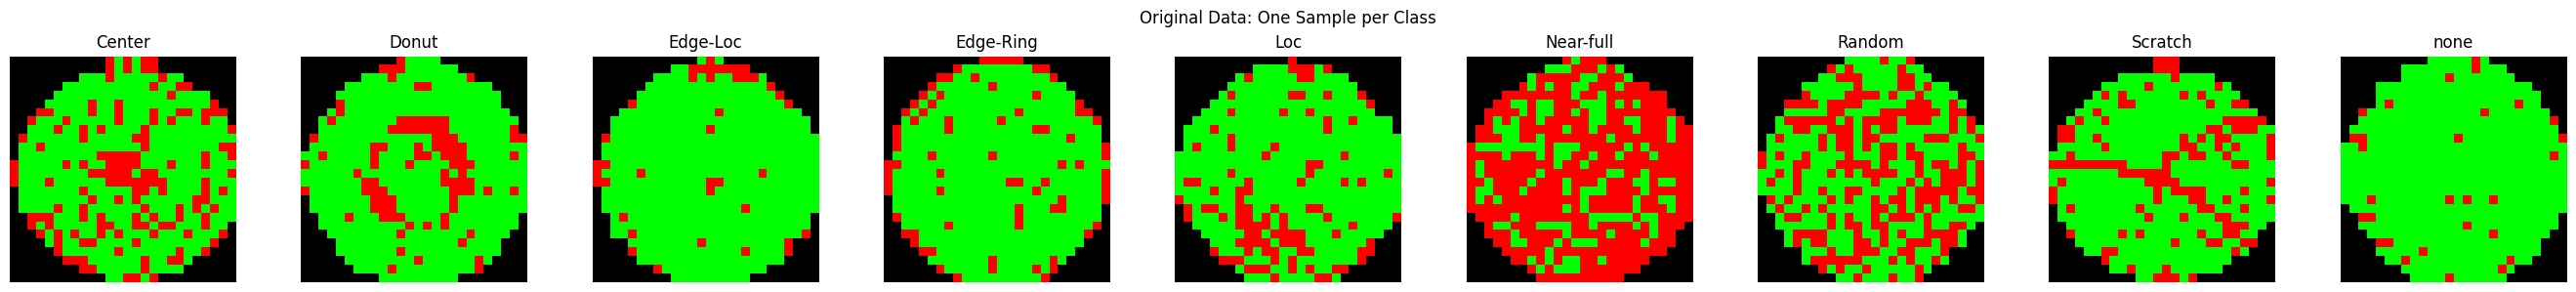


[Unlabeled Data] Display 2 samples


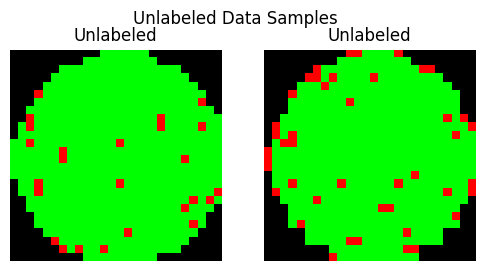


[Augmented Data] Display 2 augmented samples per class


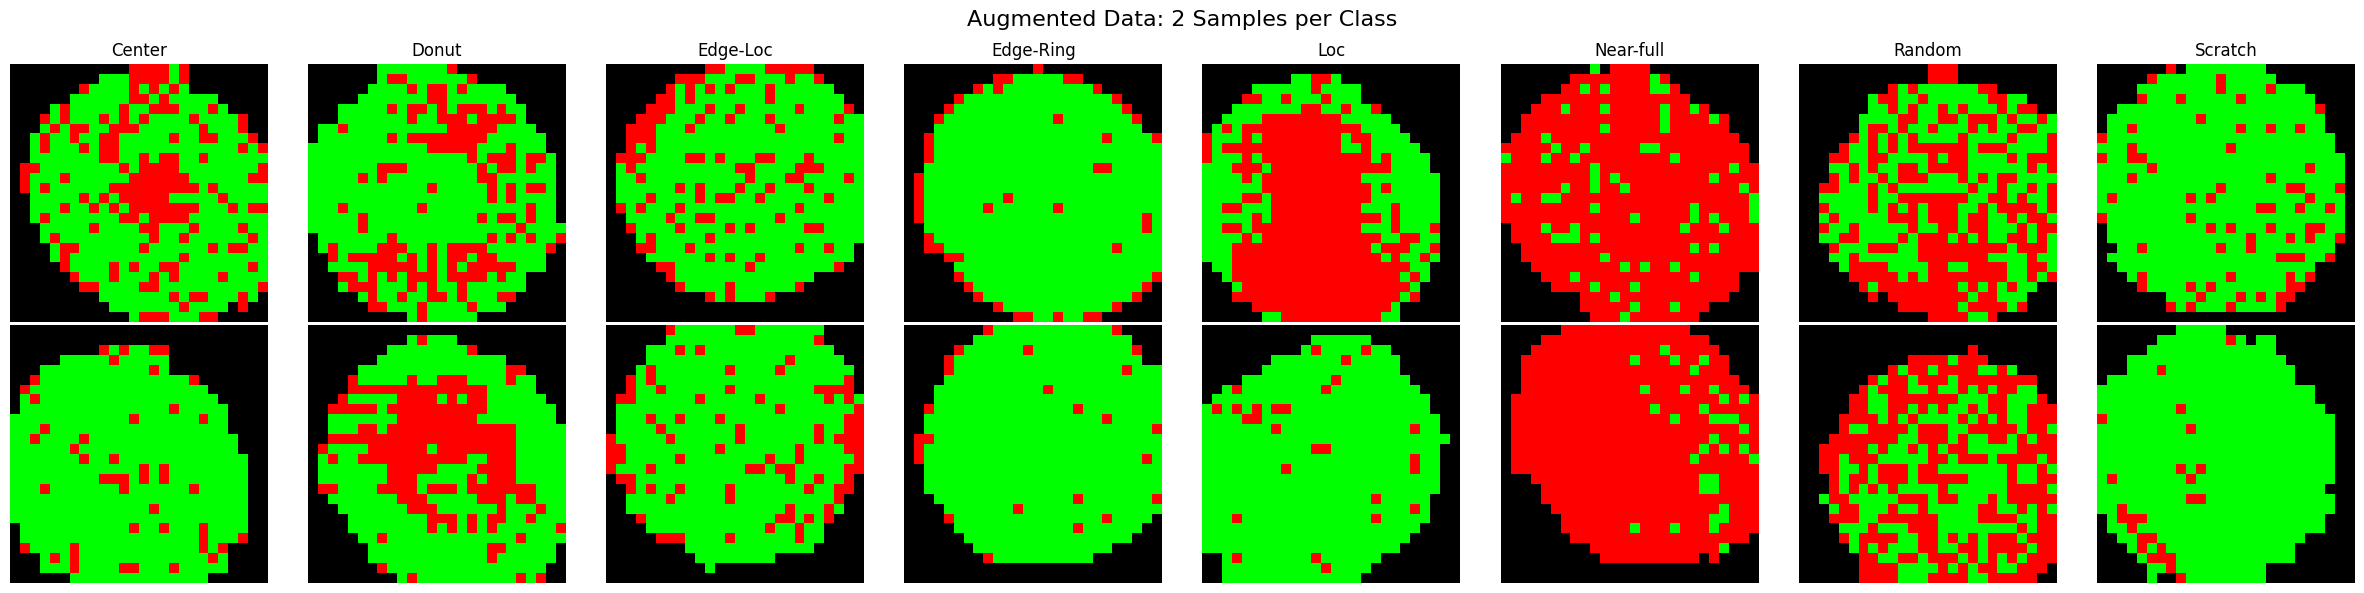


[Original vs. Augmented] Comparison per class


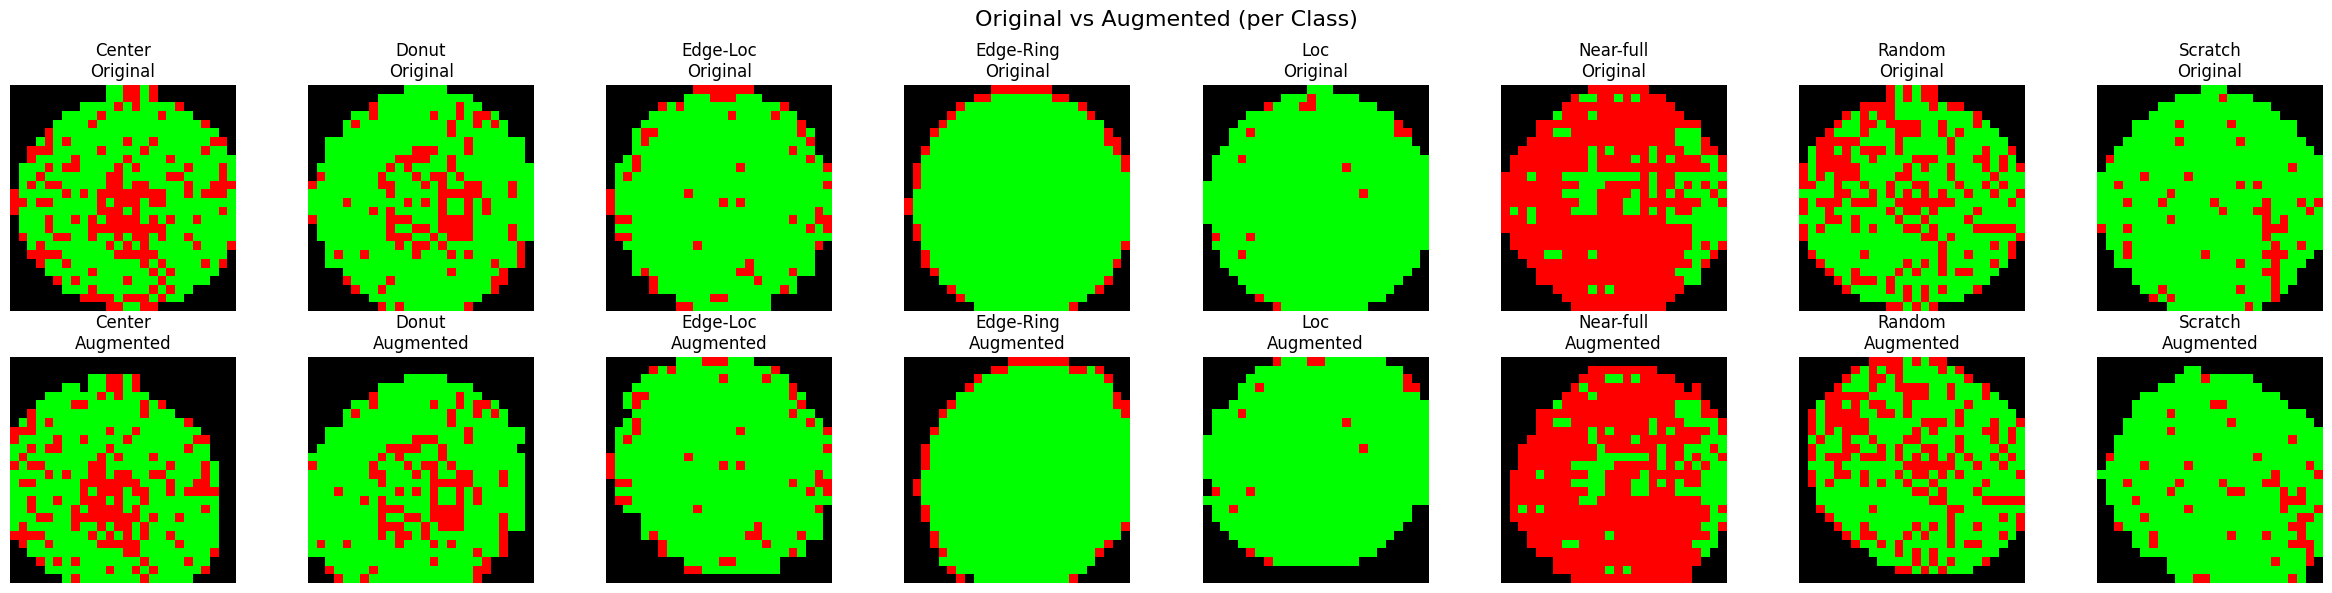


=== Supervised Experiment ===
[Supervised] Epoch 1 Loss: 1.7272
[Supervised] Epoch 2 Loss: 1.2734
[Supervised] Epoch 3 Loss: 1.0050
[Supervised] Epoch 4 Loss: 0.8447
[Supervised] Epoch 5 Loss: 0.7348
[Supervised] Epoch 6 Loss: 0.7057
[Supervised] Epoch 7 Loss: 0.6162
[Supervised] Epoch 8 Loss: 0.5852
[Supervised] Epoch 9 Loss: 0.5533
[Supervised] Epoch 10 Loss: 0.5954
[Supervised] Epoch 11 Loss: 0.4461
[Supervised] Epoch 12 Loss: 0.4203
[Supervised] Epoch 13 Loss: 0.3714
[Supervised] Epoch 14 Loss: 0.3488
[Supervised] Epoch 15 Loss: 0.3299
[Supervised] Epoch 16 Loss: 0.3016
[Supervised] Epoch 17 Loss: 0.2903
[Supervised] Epoch 18 Loss: 0.2646
[Supervised] Epoch 19 Loss: 0.2793
[Supervised] Epoch 20 Loss: 0.2496
[Supervised] Epoch 21 Loss: 0.2158
[Supervised] Epoch 22 Loss: 0.1989
[Supervised] Epoch 23 Loss: 0.2041
[Supervised] Epoch 24 Loss: 0.1888
[Supervised] Epoch 25 Loss: 0.1798
[Supervised] Epoch 26 Loss: 0.1754
[Supervised] Epoch 27 Loss: 0.1571
[Supervised] Epoch 28 Loss: 0.159

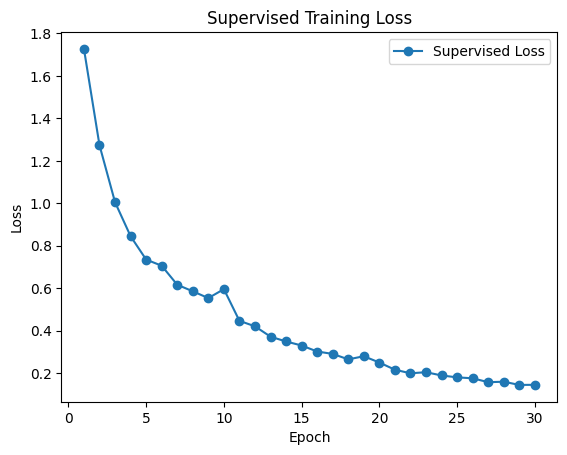

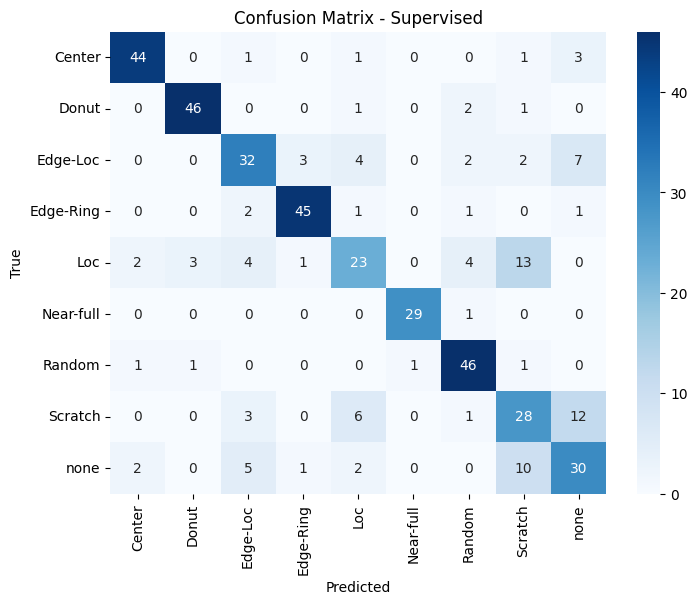


=== Semi-supervised Experiment ===
Epoch 1: Unlabeled usage ratio = 0.000 (3.0/6272)
[Semi-supervised] Epoch 1 Loss: 1.6412
Epoch 2: Unlabeled usage ratio = 0.002 (11.0/6272)
[Semi-supervised] Epoch 2 Loss: 1.1751
Epoch 3: Unlabeled usage ratio = 0.009 (58.0/6272)
[Semi-supervised] Epoch 3 Loss: 0.9838
Epoch 4: Unlabeled usage ratio = 0.024 (148.0/6272)
[Semi-supervised] Epoch 4 Loss: 0.9187
Epoch 5: Unlabeled usage ratio = 0.026 (164.0/6272)
[Semi-supervised] Epoch 5 Loss: 0.8064
Epoch 6: Unlabeled usage ratio = 0.042 (261.0/6272)
[Semi-supervised] Epoch 6 Loss: 0.7508
Epoch 7: Unlabeled usage ratio = 0.047 (296.0/6272)
[Semi-supervised] Epoch 7 Loss: 0.7139
Epoch 8: Unlabeled usage ratio = 0.050 (312.0/6272)
[Semi-supervised] Epoch 8 Loss: 0.6764
Epoch 9: Unlabeled usage ratio = 0.055 (342.0/6272)
[Semi-supervised] Epoch 9 Loss: 0.6165
Epoch 10: Unlabeled usage ratio = 0.059 (367.0/6272)
[Semi-supervised] Epoch 10 Loss: 0.5408
Epoch 11: Unlabeled usage ratio = 0.066 (415.0/6272)
[Se

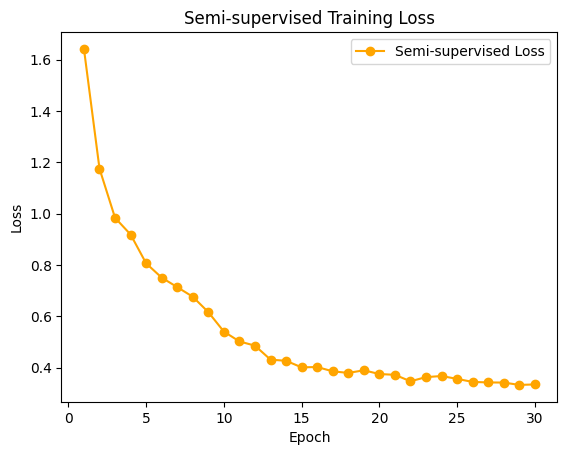

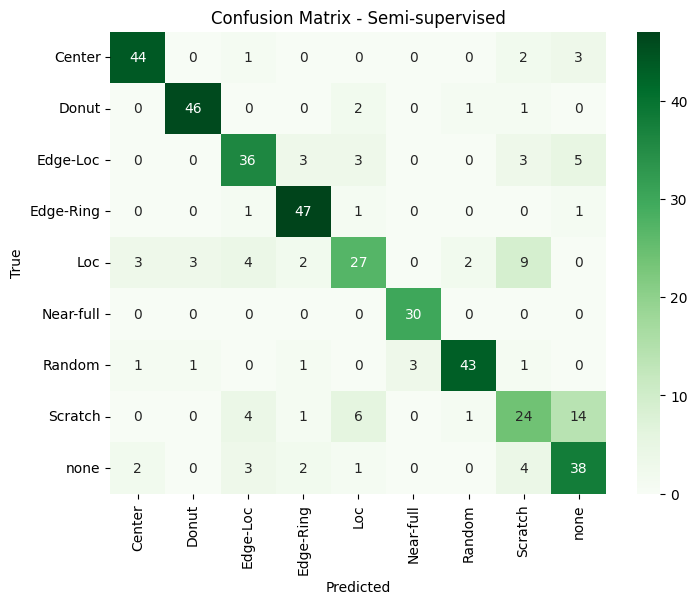

In [1]:
# fixmatch_wafer.py
import os
import random
import math
import time
import cv2
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom dataset classes
from datasets import LabeledDataset, UnlabeledDataset, TestDataset

# =====================================================
# 1. Environment Setup and Hyperparameter Settings
# =====================================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

BATCH_SIZE = 32            # Batch size for labeled data
MU = 7                     # Multiplier for unlabeled batch (BATCH_SIZE * MU)
THRESHOLD = 0.95           # Pseudo-label confidence threshold (for semi-supervised learning)
T = 1.0                    # Pseudo-label temperature
LAMBDA_U = 1.0             # Unlabeled loss weight
NUM_CLASSES = 9
LR = 1e-3
EPOCHS = 30                # Total number of epochs
TARGET_SHAPE = (26, 26)    # (height, width)

# =====================================================
# 2. Wafer Map Preprocessing Function
# =====================================================
def process_wafer_map(wafer_map, target_size=TARGET_SHAPE):
    """
    Converts the wafer_map (list) to a normalized 3-channel image.
    Color mapping:
      0 -> [0, 0, 0] (black)
      1 -> [0, 255, 0] (green)
      2 -> [255, 0, 0] (red)
    Final output: a float32 image of shape (target_size[0], target_size[1], 3) with values scaled to [0, 1].
    """
    img = np.array(wafer_map, dtype=np.uint8)
    img_resized = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    color_map = {0: [0, 0, 0],
                 1: [0, 255, 0],
                 2: [255, 0, 0]}
    colored_img = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    for key, color in color_map.items():
        colored_img[img_resized == key] = color
    return colored_img.astype(np.float32) / 255.0

# =====================================================
# 3. Data Loading and Train/Test Split (80:20)
# =====================================================
print("Loading data...")
data = pd.read_pickle('LSWMD.pkl')
print("Overall data shape:", data.shape)

# Select only labeled data (where the failureType list is non-empty)
data_labelled = data[data['failureType'].map(lambda x: len(x) != 0)].copy()
print("Labeled data shape:", data_labelled.shape)
print("Some labeled data:")
print(data_labelled.head())

# Class list (in the original order)
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

# Convert failureType values to strings for hashing
data_labelled['failureType'] = data_labelled['failureType'].map(lambda x: str(x[0][0]))
data_labelled['trianTestLabel'] = data_labelled['trianTestLabel'].map(lambda x: x[0][0])
data_labelled.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)
class_to_idx = {name: i for i, name in enumerate(classes)}
print("Class list:", classes)
print("Class to index mapping:", class_to_idx)

# Split each class into 80% train and 20% test
train_list = []
test_list = []
for cls in classes:
    df_cls = data_labelled[data_labelled['failureType'] == cls]
    df_train = df_cls.sample(frac=0.8, random_state=seed)
    df_test = df_cls.drop(df_train.index)
    train_list.append(df_train)
    test_list.append(df_test)
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Print class counts for train and test data in the desired order
print("Training data class counts:")
print(train_df['failureType'].value_counts().reindex(classes))
print("Test data class counts:")
print(test_df['failureType'].value_counts().reindex(classes))

# =====================================================
# 4. Supervised & Semi-supervised Data Sampling
# =====================================================
# [Supervised Experiment] Use at most 100 training and 50 test samples per class (or maximum available)
supervised_train_list = []
supervised_test_list = []
for cls in classes:
    df_cls_train = train_df[train_df['failureType'] == cls]
    n_train = min(len(df_cls_train), 100)
    df_sample_train = df_cls_train.sample(n=n_train, random_state=seed)
    supervised_train_list.append(df_sample_train)
    
    df_cls_test = test_df[test_df['failureType'] == cls]
    n_test = min(len(df_cls_test), 50)
    df_sample_test = df_cls_test.sample(n=n_test, random_state=seed)
    supervised_test_list.append(df_sample_test)
supervised_train_df = pd.concat(supervised_train_list).reset_index(drop=True)
supervised_test_df = pd.concat(supervised_test_list).reset_index(drop=True)
print("Supervised - Training data shape:", supervised_train_df.shape)
print("Supervised - Test data shape:", supervised_test_df.shape)

# [Semi-supervised Experiment]
# labeled: Use at most 100 samples per class
semi_sup_labeled_list = []
for cls in classes:
    df_cls = train_df[train_df['failureType'] == cls]
    n = min(len(df_cls), 100)
    df_sample = df_cls.sample(n=n, random_state=seed)
    semi_sup_labeled_list.append(df_sample)
semi_sup_labeled_df = pd.concat(semi_sup_labeled_list).reset_index(drop=True)
print("Semi-supervised - Labeled training data shape:", semi_sup_labeled_df.shape)

# unlabeled: Exclude the indices used in semi_sup_labeled_df from train_df, use up to 10000 samples
semi_sup_unlabeled_df = train_df.loc[~train_df.index.isin(semi_sup_labeled_df.index)].copy()
if len(semi_sup_unlabeled_df) >= 10000:
    semi_sup_unlabeled_df = semi_sup_unlabeled_df.sample(n=10000, random_state=seed)
else:
    semi_sup_unlabeled_df = semi_sup_unlabeled_df.copy()
print("Semi-supervised - Unlabeled training data shape:", semi_sup_unlabeled_df.shape)

# =====================================================
# 5. Image Loading (as numpy arrays) and Label Extraction
# =====================================================
def load_image_and_label(row):
    img = process_wafer_map(row['waferMap'], target_size=TARGET_SHAPE)
    label = class_to_idx.get(row['failureType'], 0)
    return img, label

# Supervised train
sup_train_images, sup_train_labels = [], []
for idx, row in supervised_train_df.iterrows():
    img, label = load_image_and_label(row)
    sup_train_images.append(img)
    sup_train_labels.append(label)
sup_train_images = np.array(sup_train_images)
sup_train_labels = np.array(sup_train_labels)

# Supervised test
sup_test_images, sup_test_labels = [], []
for idx, row in supervised_test_df.iterrows():
    img, label = load_image_and_label(row)
    sup_test_images.append(img)
    sup_test_labels.append(label)
sup_test_images = np.array(sup_test_images)
sup_test_labels = np.array(sup_test_labels)

# Semi-supervised labeled
semi_sup_labeled_images, semi_sup_labeled_labels = [], []
for idx, row in semi_sup_labeled_df.iterrows():
    img, label = load_image_and_label(row)
    semi_sup_labeled_images.append(img)
    semi_sup_labeled_labels.append(label)
semi_sup_labeled_images = np.array(semi_sup_labeled_images)
semi_sup_labeled_labels = np.array(semi_sup_labeled_labels)

# Semi-supervised unlabeled (labels are not used)
def load_image(row):
    return process_wafer_map(row['waferMap'], target_size=TARGET_SHAPE)

semi_sup_unlabeled_images = []
for idx, row in semi_sup_unlabeled_df.iterrows():
    img = load_image(row)
    semi_sup_unlabeled_images.append(img)
semi_sup_unlabeled_images = np.array(semi_sup_unlabeled_images)

# Print data structure
print("\n[Data Structure]")
print("X_train (Supervised) shape:", sup_train_images.shape, "y_train shape:", sup_train_labels.shape)
print("X_test (Supervised) shape:", sup_test_images.shape, "y_test shape:", sup_test_labels.shape)

# =====================================================
# 6. Define Data Augmentation Transforms
# =====================================================
weak_transform = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor()
])

strong_transform = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.RandomAffine(degrees=10, shear=10, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(TARGET_SHAPE),
    transforms.ToTensor()
])

# =====================================================
# [Additional] Visualization Functions
# =====================================================
def show_sample_images_labeled(images, labels, classes, num_samples=1):
    plt.figure(figsize=(3 * len(classes), 3))
    for i, cls in enumerate(classes):
        cls_idxs = np.where(labels == class_to_idx[cls])[0]
        if len(cls_idxs) == 0:
            continue
        sample_idx = np.random.choice(cls_idxs)
        plt.subplot(1, len(classes), i+1)
        plt.imshow(images[sample_idx])
        plt.title(cls)
        plt.axis('off')
    plt.suptitle("Original Data: One Sample per Class")
    plt.tight_layout()
    plt.show()

def show_augmented_images(synthetic_images, synthetic_labels, classes, samples_per_class=2):
    aug_classes = [cls for cls in classes if cls != "none"]
    n_cols = len(aug_classes)
    plt.figure(figsize=(3 * n_cols, 6))
    for i, cls in enumerate(aug_classes):
        cls_idx = class_to_idx[cls]
        idxs = np.where(synthetic_labels == cls_idx)[0]
        if len(idxs) > 0:
            if len(idxs) >= samples_per_class:
                sample_idxs = np.random.choice(idxs, size=samples_per_class, replace=False)
            else:
                sample_idxs = [idxs[0]] * samples_per_class
            # First row
            plt.subplot(2, n_cols, i+1)
            plt.imshow(synthetic_images[sample_idxs[0]])
            plt.title(cls)
            plt.axis('off')
            # Second row
            plt.subplot(2, n_cols, n_cols + i + 1)
            plt.imshow(synthetic_images[sample_idxs[1]])
            plt.axis('off')
    plt.suptitle("Augmented Data: 2 Samples per Class", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_before_after_augmentation(images, labels, classes, transform):
    """
    Visualize a side-by-side comparison of the original and strongly augmented images
    for each class (excluding 'none').
    """
    aug_classes = [cls for cls in classes if cls != "none"]
    n_cols = len(aug_classes)
    plt.figure(figsize=(3 * n_cols, 6))
    for i, cls in enumerate(aug_classes):
        cls_idx = class_to_idx[cls]
        idxs = np.where(labels == cls_idx)[0]
        if len(idxs) == 0:
            continue
        sample_idx = np.random.choice(idxs)
        orig_img = images[sample_idx]
        pil_img = Image.fromarray((orig_img * 255).astype(np.uint8))
        aug_img_tensor = transform(pil_img)
        aug_img_np = np.transpose(aug_img_tensor.numpy(), (1, 2, 0))
        # Original image
        plt.subplot(2, n_cols, i+1)
        plt.imshow(orig_img)
        plt.title(f"{cls}\nOriginal")
        plt.axis('off')
        # Augmented image
        plt.subplot(2, n_cols, n_cols + i + 1)
        plt.imshow(aug_img_np)
        plt.title(f"{cls}\nAugmented")
        plt.axis('off')
    plt.suptitle("Original vs Augmented (per Class)", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_autoencoder_comparison(images, labels, classes):
    """
    Visualize a comparison between the original and autoencoder-augmented images.
    (Requires pre-defined encoder, decoder, and discrete_postprocess functions/models.)
    """
    # Exclude 'none' class
    aug_classes = [cls for cls in classes if cls != "none"]
    plt.figure(figsize=(2 * len(aug_classes), 4))
    for i, cls in enumerate(aug_classes):
        cls_idx = class_to_idx[cls]
        idxs = np.where(labels == cls_idx)[0]
        if len(idxs) == 0:
            continue
        sample_idx = np.random.choice(idxs)
        orig_img = images[sample_idx]  # (26,26,3)
        
        # Encode -> add noise -> decode -> post-process (requires autoencoder functions)
        latent = encoder.predict(np.expand_dims(orig_img, axis=0))
        latent_noisy = latent + np.random.normal(loc=0, scale=0.2, size=latent.shape)
        aug_img_cont = decoder.predict(latent_noisy)[0]  # continuous 3-channel output
        aug_img = discrete_postprocess(aug_img_cont)       # post-process: argmax then one-hot encoding
        
        # Display original and augmented images side-by-side
        plt.subplot(2, len(aug_classes), i+1)
        plt.imshow(orig_img)
        plt.title(f"{cls}\nOriginal")
        plt.axis('off')
        plt.subplot(2, len(aug_classes), len(aug_classes)+i+1)
        plt.imshow(aug_img)
        plt.title(f"{cls}\nAugmented")
        plt.axis('off')
    plt.suptitle("Autoencoder Augmentation Comparison (per Class)", fontsize=16)
    plt.tight_layout()
    plt.show()

def show_sample_images_unlabeled(images, num_samples=2):
    if len(images) == 0:
        print("No unlabeled samples available.")
        return
    sample_indices = random.sample(range(len(images)), min(num_samples, len(images)))
    plt.figure(figsize=(3 * num_samples, 3))
    for j, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, j + 1)
        plt.imshow(images[idx])
        plt.title("Unlabeled")
        plt.axis('off')
    plt.suptitle("Unlabeled Data Samples")
    plt.show()

# =====================================================
# 7. Pre-training Visualization
# =====================================================
# Display one sample per class from the supervised training data
print("\n[Original Data] Display one sample per class")
show_sample_images_labeled(sup_train_images, sup_train_labels, classes, num_samples=1)

# Display 2 unlabeled data samples
print("\n[Unlabeled Data] Display 2 samples")
show_sample_images_unlabeled(semi_sup_unlabeled_images, num_samples=2)

# Generate synthetic images using strong augmentation (based on supervised training data)
synthetic_images = []
synthetic_labels = []
for img, label in zip(sup_train_images, sup_train_labels):
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    aug_img = strong_transform(pil_img)
    # Convert tensor to numpy (change channel order)
    aug_img_np = np.transpose(aug_img.numpy(), (1, 2, 0))
    synthetic_images.append(aug_img_np)
    synthetic_labels.append(label)
synthetic_images = np.array(synthetic_images)
synthetic_labels = np.array(synthetic_labels)

# Display 2 augmented samples per class
print("\n[Augmented Data] Display 2 augmented samples per class")
show_augmented_images(synthetic_images, synthetic_labels, classes, samples_per_class=2)

# ----------------------------------------------------------------
# [Additional] Compare Original vs. Strongly Augmented Images per Class
print("\n[Original vs. Augmented] Comparison per class")
show_before_after_augmentation(sup_train_images, sup_train_labels, classes, strong_transform)

# Autoencoder augmentation comparison (requires encoder, decoder, discrete_postprocess)
# Uncomment the lines below if the Autoencoder modules are available.
# print("\n[Autoencoder Augmentation Comparison] Display one sample per class")
# show_autoencoder_comparison(sup_train_images, sup_train_labels, classes)

# =====================================================
# 8. Create Datasets and DataLoaders
# =====================================================
sup_train_dataset = LabeledDataset(sup_train_images, sup_train_labels, transform=weak_transform)
sup_test_dataset = TestDataset(sup_test_images, sup_test_labels, transform=test_transform)
sup_train_loader = DataLoader(sup_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
sup_test_loader = DataLoader(sup_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

semi_sup_labeled_dataset = LabeledDataset(semi_sup_labeled_images, semi_sup_labeled_labels, transform=weak_transform)
semi_sup_unlabeled_dataset = UnlabeledDataset(semi_sup_unlabeled_images, weak_transform=weak_transform, strong_transform=strong_transform)
semi_sup_labeled_loader = DataLoader(semi_sup_labeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
semi_sup_unlabeled_loader = DataLoader(semi_sup_unlabeled_dataset, batch_size=BATCH_SIZE * MU, shuffle=True, num_workers=2, drop_last=True)

# =====================================================
# 9. Model Definition (Simple CNN)
# =====================================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 26 -> 13
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Second pooling: 13 -> 6 (floor division)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * 6 * 6, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================================================
# 10. Training Loop and Evaluation Functions (Including Confusion Matrix)
# =====================================================
def train_supervised(model, loader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    num_iter = len(loader)
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / num_iter

def train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    unlabeled_used_total = 0  # Count of unlabeled samples that exceeded threshold
    unlabeled_total = 0       # Total count of unlabeled samples
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    num_iter = min(len(labeled_loader), len(unlabeled_loader))
    
    for _ in range(num_iter):
        try:
            inputs_x, targets_x = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            inputs_x, targets_x = next(labeled_iter)
        try:
            inputs_u_w, inputs_u_s = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            inputs_u_w, inputs_u_s = next(unlabeled_iter)
        
        inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
        inputs_u_w = inputs_u_w.to(device)
        inputs_u_s = inputs_u_s.to(device)
        
        # Labeled loss
        logits_x = model(inputs_x)
        loss_x = criterion(logits_x, targets_x)
        
        # Generate pseudo-labels for unlabeled data (using weak augmentation)
        with torch.no_grad():
            logits_u_w = model(inputs_u_w)
            pseudo_label = torch.softmax(logits_u_w / T, dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = (max_probs >= THRESHOLD).float()
        
        unlabeled_used_total += mask.sum().item()
        unlabeled_total += mask.numel()
        
        # Unlabeled loss (using strong augmentation)
        logits_u_s = model(inputs_u_s)
        loss_u = (criterion(logits_u_s, targets_u) * mask).mean()
        
        loss = loss_x + LAMBDA_U * loss_u
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / num_iter
    usage_ratio = unlabeled_used_total / unlabeled_total if unlabeled_total > 0 else 0
    print(f"Epoch {epoch}: Unlabeled usage ratio = {usage_ratio:.3f} ({unlabeled_used_total}/{unlabeled_total})")
    return avg_loss

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    acc = 100.0 * correct / total
    report = classification_report(all_targets, all_preds, target_names=classes)
    return acc, report, all_preds, all_targets

criterion = nn.CrossEntropyLoss(reduction='mean')

# =====================================================
# 11. Run Experiments: Supervised vs. Semi-supervised
# =====================================================
if __name__ == '__main__':
    # ---------------------- Supervised Experiment ----------------------
    print("\n=== Supervised Experiment ===")
    model_sup = SimpleCNN(num_classes=NUM_CLASSES).to(device)
    optimizer_sup = torch.optim.Adam(model_sup.parameters(), lr=LR)
    scheduler_sup = torch.optim.lr_scheduler.StepLR(optimizer_sup, step_size=10, gamma=0.5)
    supervised_losses = []
    for epoch in range(1, EPOCHS + 1):
        loss_sup = train_supervised(model_sup, sup_train_loader, optimizer_sup, epoch, device)
        supervised_losses.append(loss_sup)
        scheduler_sup.step()
        print(f"[Supervised] Epoch {epoch} Loss: {loss_sup:.4f}")
    acc_sup, report_sup, preds_sup, targets_sup = evaluate(model_sup, sup_test_loader, device)
    print("\n[Supervised Experiment Results]")
    print(f"Test Accuracy: {acc_sup:.2f}%")
    print(report_sup)
    
    # Plot training loss curve for Supervised experiment
    plt.figure()
    plt.plot(range(1, EPOCHS+1), supervised_losses, marker='o', label='Supervised Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Supervised Training Loss")
    plt.legend()
    plt.show()
    
    # Confusion Matrix for Supervised experiment
    cm_sup = confusion_matrix(targets_sup, preds_sup)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_sup, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Supervised")
    plt.show()
    
    # ---------------------- Semi-supervised Experiment ----------------------
    print("\n=== Semi-supervised Experiment ===")
    model_semi = SimpleCNN(num_classes=NUM_CLASSES).to(device)
    optimizer_semi = torch.optim.Adam(model_semi.parameters(), lr=LR)
    scheduler_semi = torch.optim.lr_scheduler.StepLR(optimizer_semi, step_size=10, gamma=0.5)
    semi_losses = []
    for epoch in range(1, EPOCHS + 1):
        loss_semi = train_fixmatch(model_semi, semi_sup_labeled_loader, semi_sup_unlabeled_loader, optimizer_semi, epoch, device)
        semi_losses.append(loss_semi)
        scheduler_semi.step()
        print(f"[Semi-supervised] Epoch {epoch} Loss: {loss_semi:.4f}")
    acc_semi, report_semi, preds_semi, targets_semi = evaluate(model_semi, sup_test_loader, device)
    print("\n[Semi-supervised Experiment Results]")
    print(f"Test Accuracy: {acc_semi:.2f}%")
    print(report_semi)
    
    # Plot training loss curve for Semi-supervised experiment
    plt.figure()
    plt.plot(range(1, EPOCHS+1), semi_losses, marker='o', color='orange', label='Semi-supervised Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Semi-supervised Training Loss")
    plt.legend()
    plt.show()
    
    # Confusion Matrix for Semi-supervised experiment
    cm_semi = confusion_matrix(targets_semi, preds_semi)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_semi, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Greens")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Semi-supervised")
    plt.show()
